In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy import stats
# import missingno as msno
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import matplotlib.pyplot as plt
import warnings
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


In [2]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion


# Kaggle's Bike Sharing Demand 

## Overview

## Introduction

### Original Features
- datetime - hourly date + timestamp  
- season - 
    - 1 = spring
    - 2 = summer
    - 3 = fall 
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

## Basic Analysis
* histogram the data
* create feature correlation heatmap
* add time features (year,year-month,month,week_number,day_of_week,day,hour)
* use log transformer 
* test increase demand year-over-year, month-over-month,

## Feature Ingeneering
* use desicision tree to convert hours into bins
* use desicision tree to convert temps into bins
* create dummy variables
* seperate data to casual and registered



### Sources
our challange:
* https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/
* https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
* https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile

How to use XGBoost:
* For Dummies - https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
* http://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/XG_Boost_NB.ipynb
* https://github.com/dmlc/xgboost/blob/master/doc/parameter.md


Trasnformers for inbalanced data:
http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html


# EDA 

## Basic exploration and visualization



In [3]:
ods_bike_raw = pd.read_csv('C:\\Users\\Roy\\Dropbox\\GitHub\\Final Project\\source_files\\train.csv')
ods_bike = ods_bike_raw.copy()
ods_bike.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [4]:
ods_bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
ods_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [6]:
# # def defome_working_hours(data):
# #     data[is_working_hours] = 
    
# # Create variable with TRUE if nationality is USA
# cond1 = ods_bike['workingday'] == 1

# # Create variable with TRUE if age is greater than 50
# cond2 = (ods_bike['month'] == '01') or (ods_bike['month'] == '02')

# # Select all casess where nationality is USA and age is greater than 50
# ods_bike[cond1 & cond2]
    
# # ods_bike.head()

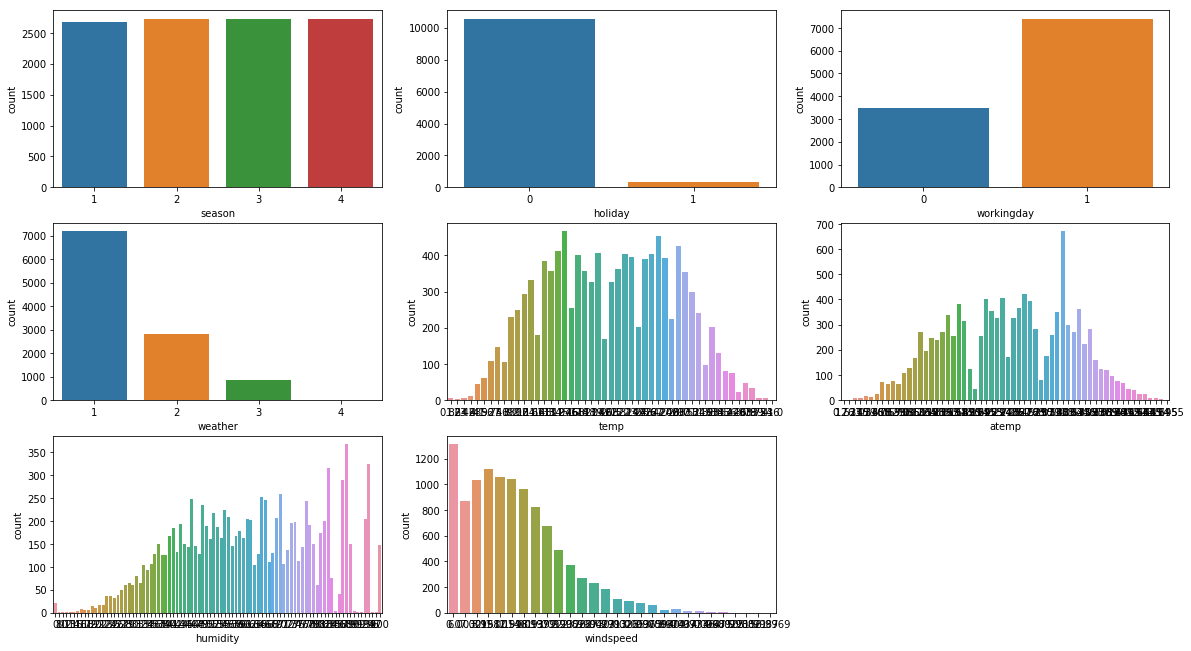

In [7]:
ods_bike_columns = ['season', 'holiday', 'workingday', 'weather', 'temp',
                    'atemp', 'humidity', 'windspeed']

plt.subplots(figsize=(20,15))
for x in range(len(ods_bike_columns)):
    plt.subplot(4,3,x+1)
    sns.countplot(ods_bike_columns[x],data=ods_bike) 

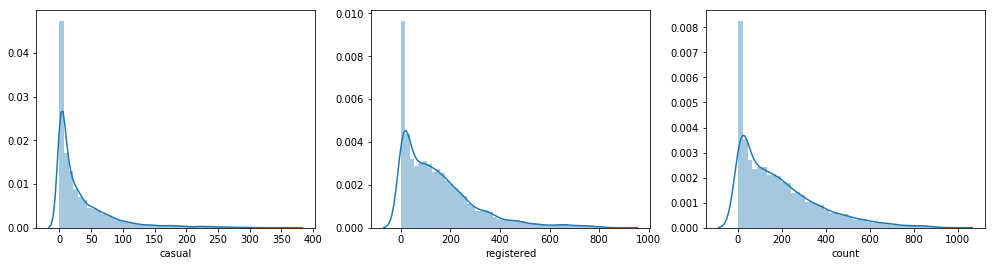

In [8]:
target_columns = ['casual', 'registered', 'count']   
plt.subplots(figsize=(17,4))
for i in range(len(target_columns)):
    plt.subplot(1,3,i+1)
    sns.distplot(ods_bike[target_columns[i]])

#### Insights 1
* targets ( data is not normally distributed

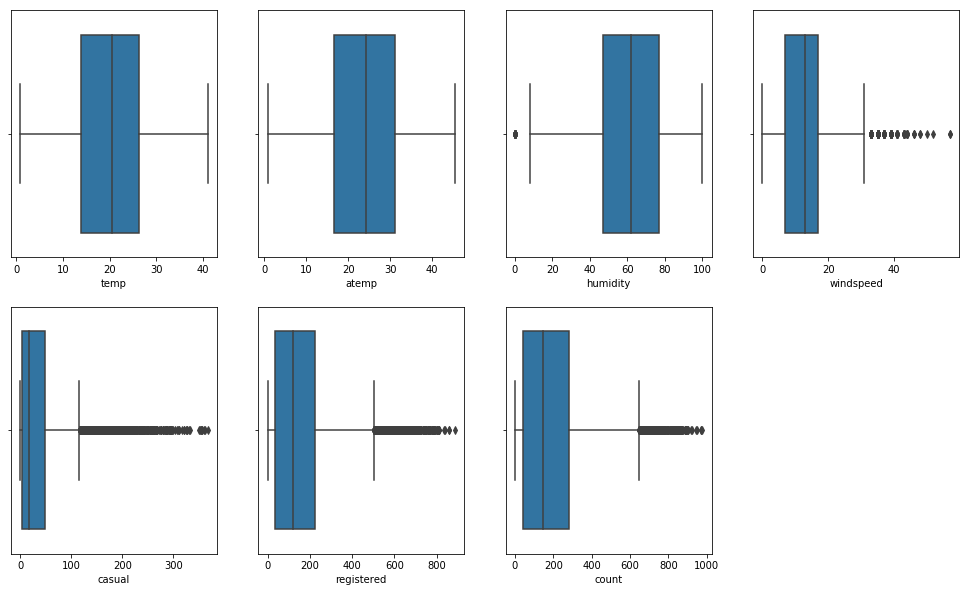

In [9]:
ods_bike_columns = ['temp','atemp', 'humidity', 'windspeed','casual', 'registered', 'count']

plt.subplots(figsize=(17,10))
for x in range(len(ods_bike_columns)):
    plt.subplot(2,4,x+1)
    sns.boxplot(ods_bike_columns[x],data=ods_bike) 

# EDA

## Basic feature engineering 
### Round Fractions (in order to simplify visualizations)

In [10]:
def round_fractions(data):
    data['atemp_round'] = data['atemp'].apply(round)
    data['temp_round'] = data['temp'].apply(round)
    data['windspeed_round'] = data['windspeed'].apply(round)
    
round_fractions_transformer = FunctionTransformer(func=round_fractions, validate=False)
    
round_fractions(ods_bike)
ods_bike.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,atemp_round,temp_round,windspeed_round
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,14,10,0


### Add time measures (in order to explore the data)

In [11]:
def add_time_measures(df):
#     Convert df.datetime to datetime:
    try:
        df['datetime']=df['datetime'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    except TypeError:
        pass
#     add various time measures:
    df['year'] = df['datetime'].apply(lambda x: x.date().year)
    df['month'] = df['datetime'].apply(lambda x: x.date().month)
    df['weekday'] = df['datetime'].apply(lambda x: x.date().weekday())
    df['day'] = df['datetime'].apply(lambda x: x.date().day)
    df['hour'] = df['datetime'].apply(lambda x: x.time().hour)

add_time_measures(ods_bike)

ods_bike.head(1)

add_time_measures_transformer = FunctionTransformer(func=add_time_measures, validate=False)


In [12]:
ods_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
datetime           10886 non-null datetime64[ns]
season             10886 non-null int64
holiday            10886 non-null int64
workingday         10886 non-null int64
weather            10886 non-null int64
temp               10886 non-null float64
atemp              10886 non-null float64
humidity           10886 non-null int64
windspeed          10886 non-null float64
casual             10886 non-null int64
registered         10886 non-null int64
count              10886 non-null int64
atemp_round        10886 non-null int64
temp_round         10886 non-null int64
windspeed_round    10886 non-null int64
year               10886 non-null int64
month              10886 non-null int64
weekday            10886 non-null int64
day                10886 non-null int64
hour               10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(16)
memory usage: 1.7 MB


# EDA

## Categorical feature analysis

### Season

Text(0.5,1,'Casual Demand (Daily)')

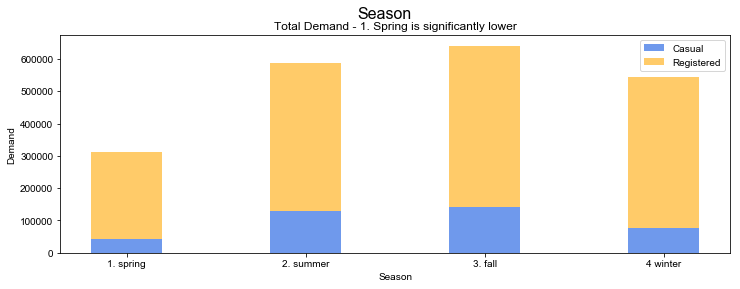

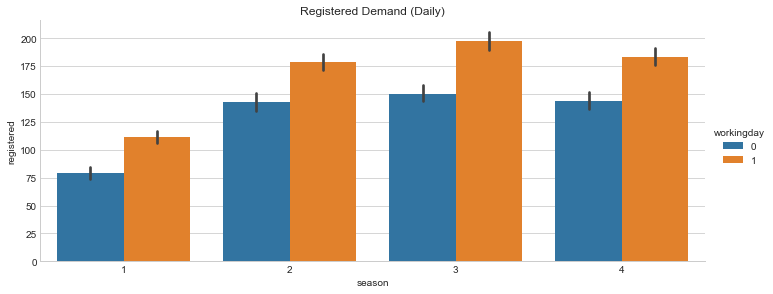

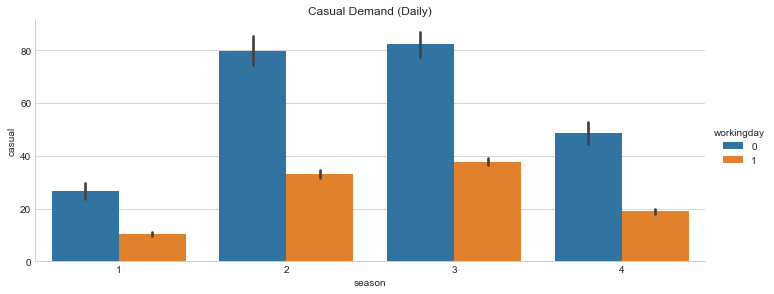

In [13]:
series_a = ods_bike.groupby('season')['casual'].sum().tolist()
series_b = ods_bike.groupby('season')['registered'].sum().tolist()
x_titles = ['1. spring','2. summer','3. fall','4 winter']
y_titles = ['Casual','Registered']

plt.subplots(figsize=(12,4))
p1 = plt.bar(x_titles, series_a, width = 0.4, color='#6F99EC')
p2 = plt.bar(x_titles, series_b, width = 0.4, color='#FFCB69',
             bottom=series_a)

plt.ylabel('Demand')
plt.xlabel('Season')
plt.title('Total Demand - 1. Spring is significantly lower')

plt.legend((p1[0], p2[0]), y_titles)

plt.suptitle('Season', fontsize=16)

sns.set_style("whitegrid")

sns.factorplot(x="season",
               y="registered",
               data= ods_bike[['registered','workingday',"season"]], 
               hue="workingday",
               kind="bar",
               size=4, 
               aspect=2.5);
plt.title('Registered Demand (Daily)')

sns.factorplot(x="season",
               y="casual",
               data= ods_bike[['casual','workingday',"season"]], 
               hue="workingday",
               kind="bar",
               size=4, 
               aspect=2.5);
plt.title('Casual Demand (Daily)')



# EDA

## Categorical feature analysis

### Year by Month

Text(0.5,1,'Casual Demand (Daily)')

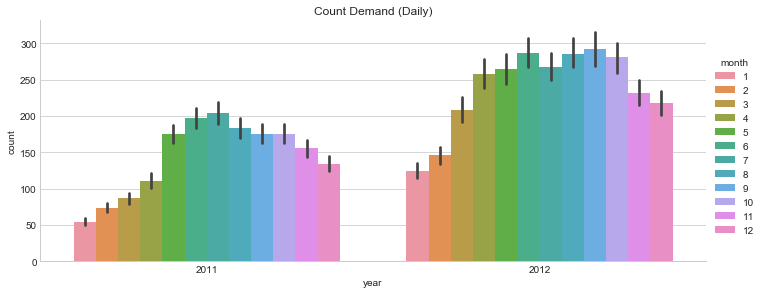

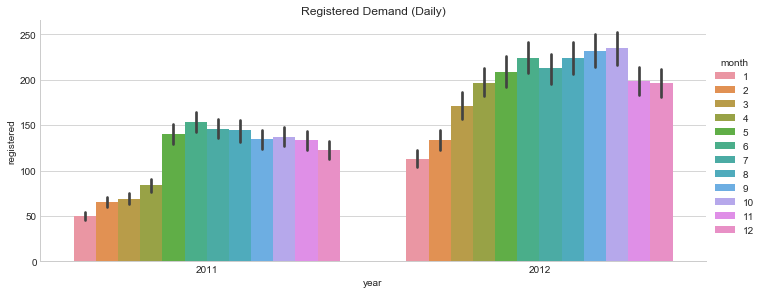

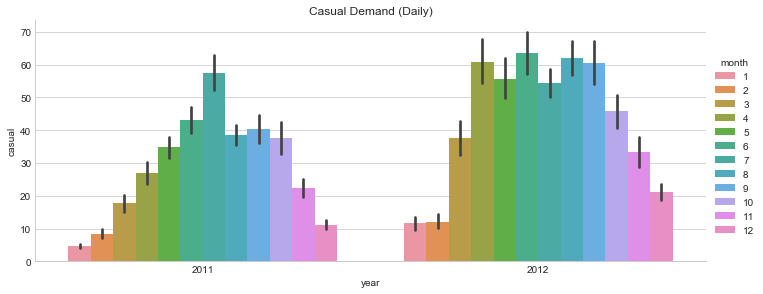

In [14]:
sns.factorplot(x="year",
               y="count",
#                col=temp_col,
               data= ods_bike[['count','year',"month"]], 
               hue="month",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Count Demand (Daily)')

sns.factorplot(x="year",
               y="registered",
#                col=temp_col,
               data= ods_bike[['registered','year',"month"]], 
               hue="month",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Registered Demand (Daily)')

sns.factorplot(x="year",
               y="casual",
#                col=temp_col,
               data= ods_bike[['casual','year',"month"]], 
               hue="month",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Casual Demand (Daily)')

# EDA

## Categorical feature analysis

### Month by Year

Text(0.5,1,'Registered Demand (Daily)')

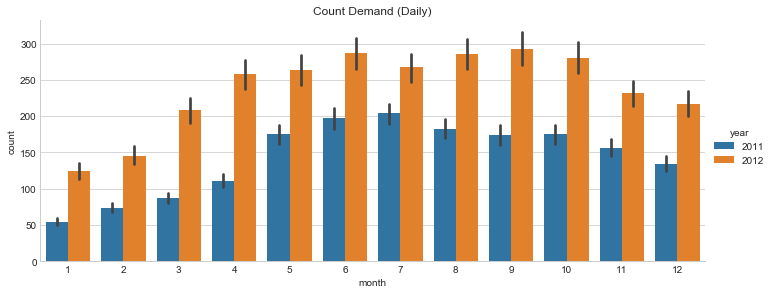

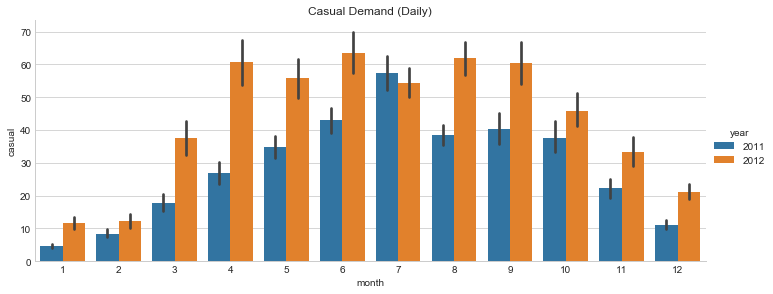

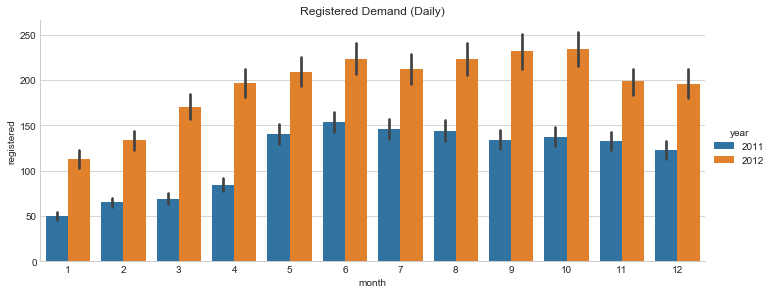

In [15]:
sns.factorplot(x="month",
               y="count",
#                col=temp_col,
               data= ods_bike[['count','year',"month"]], 
               hue="year",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Count Demand (Daily)')

sns.factorplot(x="month",
               y="casual",
#                col=temp_col,
               data= ods_bike[['casual','year',"month"]], 
               hue="year",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Casual Demand (Daily)')

sns.factorplot(x="month",
               y="registered",
#                col=temp_col,
               data= ods_bike[['registered','year',"month"]], 
               hue="year",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Registered Demand (Daily)')

# EDA

## Categorical feature analysis

### Year by Season

Text(0.5,1,'Casual Demand (Daily)')

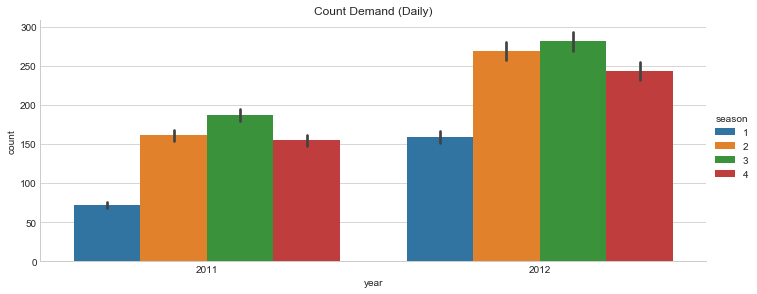

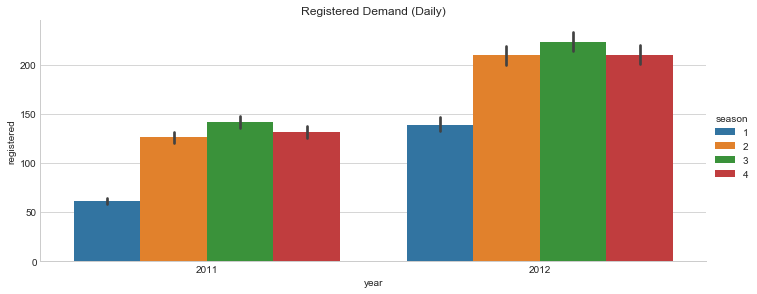

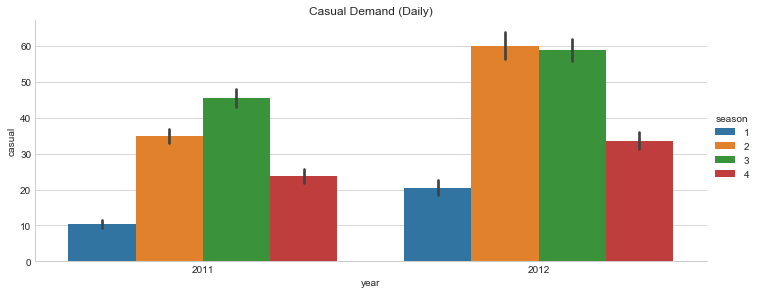

In [16]:
sns.factorplot(x="year",
               y="count",
#                col=temp_col,
               data= ods_bike[['count','year',"season"]], 
               hue="season",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Count Demand (Daily)')

sns.factorplot(x="year",
               y="registered",
#                col=temp_col,
               data= ods_bike[['registered','year',"season"]], 
               hue="season",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Registered Demand (Daily)')

sns.factorplot(x="year",
               y="casual",
#                col=temp_col,
               data= ods_bike[['casual','year',"season"]], 
               hue="season",
               kind="bar",
#                col="season",
               size=4, 
               aspect=2.5);
plt.title('Casual Demand (Daily)')

# EDA

## Categorical feature analysis

### Temp

Text(0.5,1,'Casual Daily Demand w Workingday')

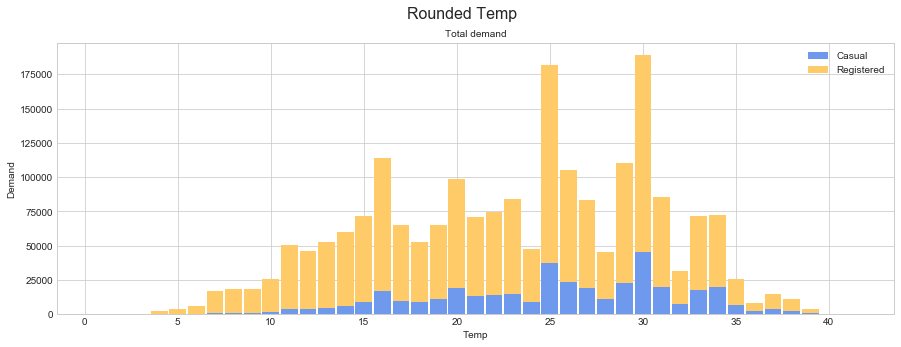

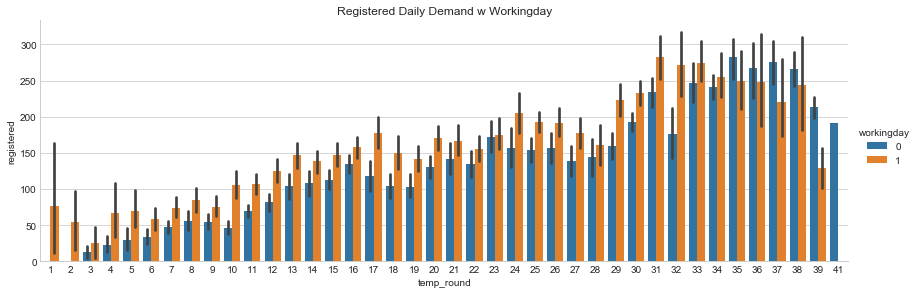

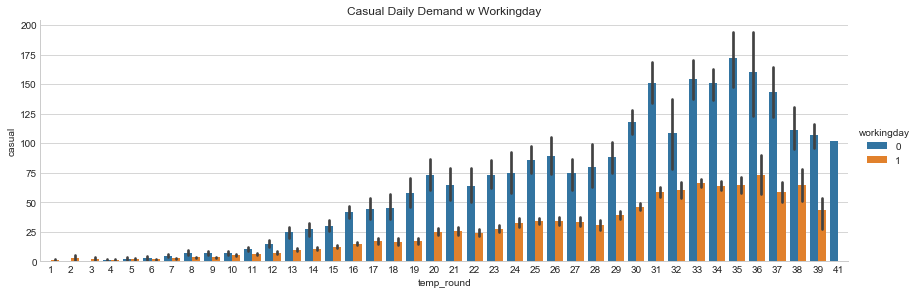

In [17]:
series_a = ods_bike.groupby('temp_round')['casual'].sum().tolist()
series_b = ods_bike.groupby('temp_round')['registered'].sum().tolist()
x_titles = ods_bike.groupby('temp_round')['casual'].sum().index.tolist()
y_titles = ['Casual','Registered']

plt.subplots(figsize=(15,5))
p1 = plt.bar(x_titles, series_a, width = 0.9, color='#6F99EC')
p2 = plt.bar(x_titles, series_b, width = 0.9, color='#FFCB69',bottom=series_a)

plt.ylabel('Demand', fontsize=10)
plt.xlabel('Temp', fontsize=10)
plt.title('Total demand', fontsize=10)

plt.legend((p1[0], p2[0]), y_titles)

plt.suptitle('Rounded Temp', fontsize=16)

sns.set_style("whitegrid")


sns.factorplot(x="temp_round",
               y='registered',
#                col=temp_col,
               data= ods_bike[['temp_round','registered','workingday']], 
               hue='workingday',
               kind="bar",
               size=4, 
               aspect=3);
plt.title('Registered Daily Demand w Workingday')

sns.factorplot(x="temp_round",
               y='casual',
#                col=temp_col,
               data= ods_bike[['temp_round','casual',"workingday"]], 
               hue="workingday",
               kind="bar",
               size=4, 
               aspect=3);
plt.title('Casual Daily Demand w Workingday')




# EDA

## Categorical feature analysis

### Windspeed

Text(0.5,1,'Daily Demand - !windspeed over 40 are outliers, should be removed!')

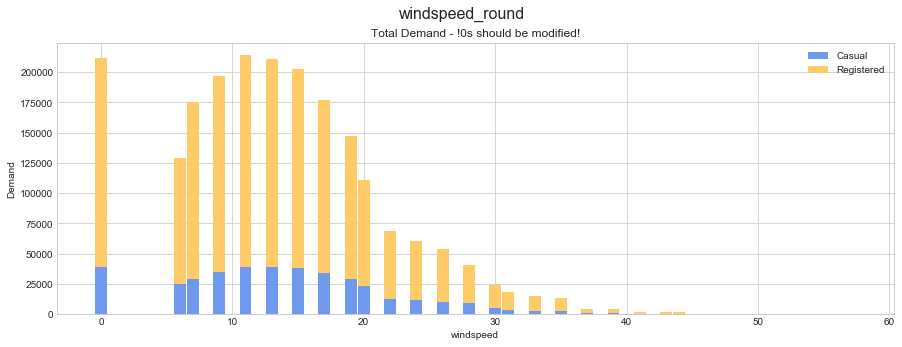

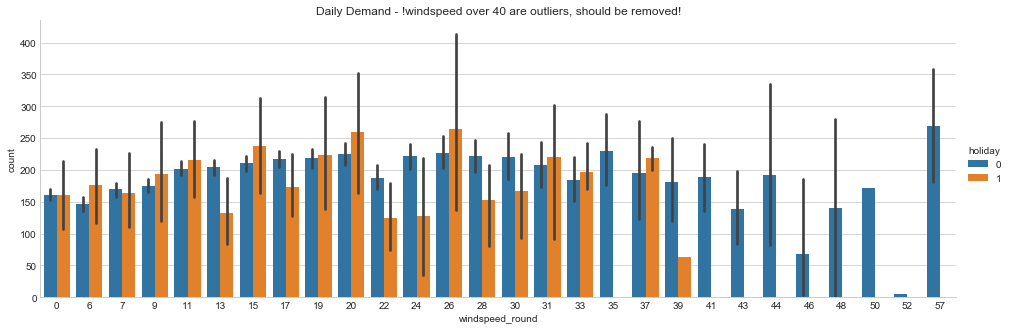

In [18]:
series_a = ods_bike.groupby('windspeed_round')['casual'].sum().tolist()
series_b = ods_bike.groupby('windspeed_round')['registered'].sum().tolist()
x_titles = ods_bike.groupby('windspeed_round')['casual'].sum().index.tolist()
y_titles = ['Casual','Registered']

plt.subplots(figsize=(15,5))
p1 = plt.bar(x_titles, series_a, width = 0.9, color='#6F99EC')
p2 = plt.bar(x_titles, series_b, width = 0.9, color='#FFCB69',bottom=series_a)

plt.ylabel('Demand')
plt.xlabel('windspeed')
plt.title('Total Demand - !0s should be modified!')

plt.legend((p1[0], p2[0]), y_titles)

plt.suptitle('windspeed_round', fontsize=16)

sns.set_style("whitegrid")


sns.factorplot(x="windspeed_round",
               y='count',
#                col=temp_col,
               data= ods_bike[['windspeed_round','count',"holiday"]], 
               hue="holiday",
               kind="bar",
               size=4.5, 
               aspect=3);
plt.title('Daily Demand - !windspeed over 40 are outliers, should be removed!')


# EDA

## Categorical feature analysis

### Month / Hour heatmap

##### Casual demand: 
* Peaks at 14:00 on working days.
* Peaks at 17:00 on non-working days.
* is lower on working days. 

Text(0.5,0.98,'Registered - Month by Hour (Daily Demand)')

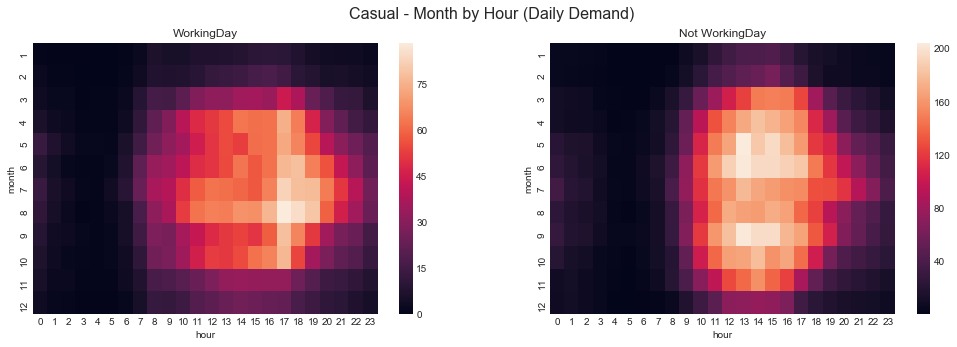

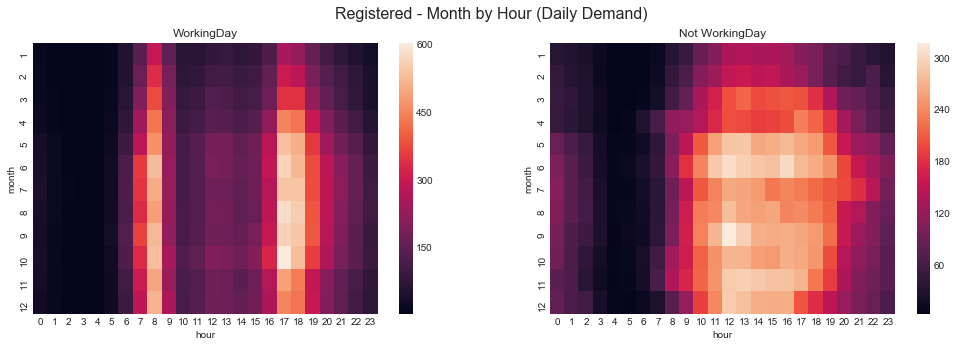

In [19]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(17, 5)

sns.heatmap(pd.pivot_table(ods_bike[ods_bike.workingday == 1], values='casual', index=['month'],columns=['hour'],aggfunc=np.mean)
            ,ax=ax[0]
            ).set_title('WorkingDay')

sns.heatmap(pd.pivot_table(ods_bike[ods_bike.workingday == 0], values='casual', index=['month'],columns=['hour'],aggfunc=np.mean)
            ,ax=ax[1]
            ).set_title('Not WorkingDay')

plt.suptitle('Casual - Month by Hour (Daily Demand)', fontsize=16)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(17, 5)

sns.heatmap(pd.pivot_table(ods_bike[ods_bike.workingday == 1], values='registered', index=['month'],columns=['hour'],aggfunc=np.mean)
            ,ax=ax[0]
            ).set_title('WorkingDay')

sns.heatmap(pd.pivot_table(ods_bike[ods_bike.workingday == 0], values='registered', index=['month'],columns=['hour'],aggfunc=np.mean)
            ,ax=ax[1]
            ).set_title('Not WorkingDay')
plt.suptitle('Registered - Month by Hour (Daily Demand)', fontsize=16)

# EDA

## Categorical feature analysis

### hour

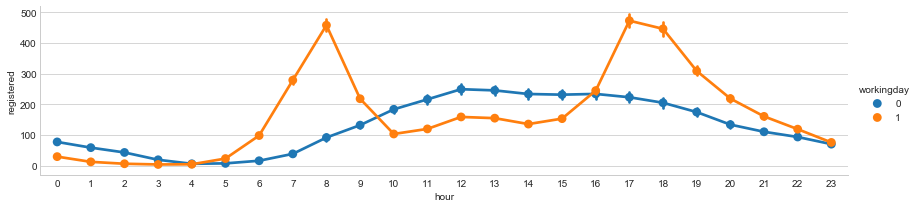

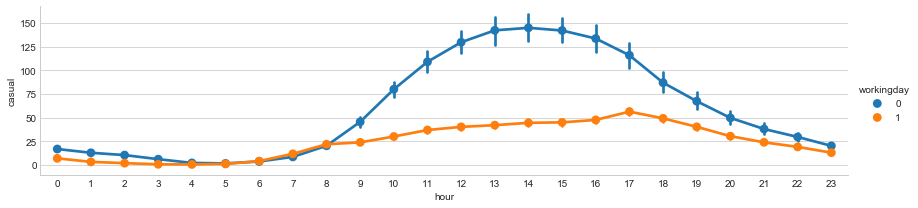

In [20]:
sns.factorplot(x='hour',y='registered',hue='workingday',data=ods_bike,size=3,aspect=4)
sns.factorplot(x='hour',y='casual',hue='workingday',data=ods_bike,size=3,aspect=4)

# Feature Engineering 

## Target Columns

### Consider using transformers

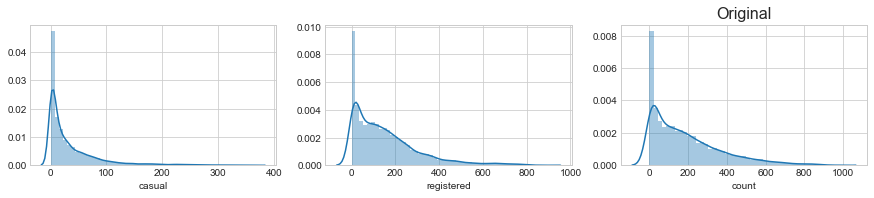

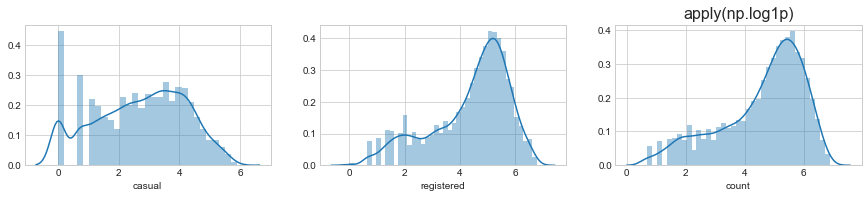

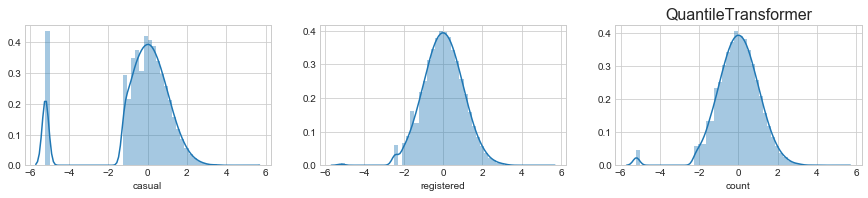

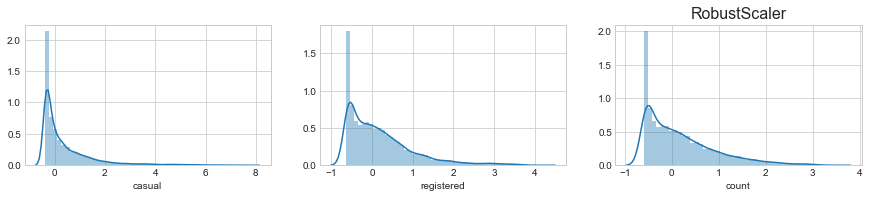

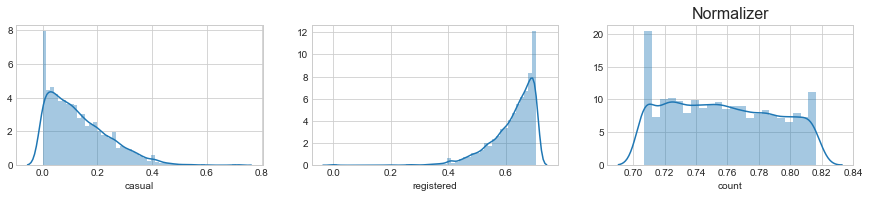

In [21]:


target_columns = ['casual', 'registered', 'count']

ods_bike.name = 'Original'

temp_bike_log1p = ods_bike.copy()
temp_bike_log1p[target_columns] = temp_bike_log1p[target_columns].apply(np.log1p)
temp_bike_log1p.name = 'apply(np.log1p)'

temp_bike_quant = ods_bike.copy()
temp_bike_quant[target_columns] = QuantileTransformer(output_distribution='normal').fit_transform(temp_bike_quant[target_columns])
# temp_bike_quant[target_columns] = QuantileTransformer(output_distribution='uniform').fit_transform(temp_bike_quant[target_columns])
temp_bike_quant.name = 'QuantileTransformer'

temp_bike_robu = ods_bike.copy()
temp_bike_robu[target_columns] = RobustScaler().fit_transform(temp_bike_robu[target_columns])
temp_bike_robu.name = 'RobustScaler'

temp_bike_norm = ods_bike.copy()
temp_bike_norm[target_columns] = Normalizer().fit_transform(temp_bike_norm[target_columns])
temp_bike_norm.name = 'Normalizer'

# RobustScaler(quantile_range=(25, 75)).fit_transform(X)),


plot_options = [ods_bike,temp_bike_log1p,temp_bike_quant,temp_bike_robu,temp_bike_norm]

for option in plot_options:  
    plt.subplots(figsize=(15,15))
    for i in range(len(target_columns)):
        plt.subplot(5,3,i+1)
        sns.distplot(option[target_columns[i]])
    plt.title(option.name, fontsize=16)

## Transform the target variables

In [22]:
def get_target_cols(df):
    return df[['casual', 'registered', 'count']]

targets_selector = FunctionTransformer(func=get_target_cols, validate=False)

In [23]:
log1p_transformer = FunctionTransformer(np.log1p)                                   
quant_transformer = QuantileTransformer(output_distribution='normal')
robust_transformer = RobustScaler()
norm_transformer = Normalizer()

all_transfomers = [log1p_transformer,quant_transformer,robust_transformer,norm_transformer]

In [24]:
targets_pipeline = Pipeline([
                            ('select_targets',targets_selector),
                            ('transform_targets',FunctionTransformer(np.log1p))
                            ])
targets_parameters = dict(transform_targets=all_transfomers)
# Cosider adding a scaler

grid_search = GridSearchCV(targets_pipeline,param_grid=targets_parameters)



NameError: name 'GridSearchCV' is not defined

# Feature Engineering 

## Numeric Features

### Remove outliers from Windspeed

In [ ]:
def remove_windspeed_outliers(data):
        data['windspeed'] = data['windspeed'].apply(lambda x: x if x < 40 else 40)
        data['windspeed_round'] = data['windspeed_round'].apply(lambda x: x if x < 40 else 40)
        
remove_windspeed_outliers(ods_bike)

plt.subplots(figsize=(15,3))
sns.countplot(x='windspeed_round',data=ods_bike)
sns.factorplot(x='windspeed_round',y='count',data=ods_bike,size=3,aspect=4)


# Feature Engineering 

## Numeric Features

### Converting Hour to bins in dummy variables

### Find best bins using decision tree:

 

In [ ]:
def hour_to_bins(df):

# Testing the model

In [ ]:
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
dwh_bike = ods_bike.copy()
dwh_bike = dwh_bike.drop('datetime',axis=1)
dwh_bike.head()

In [ ]:

clf_LR = LogisticRegression()

clf_DT = DecisionTreeClassifier(max_depth=300,
                                min_samples_split=10,
                                min_samples_leaf=10)

clf_XG = xg.XGBRegressor()

In [ ]:
X = dwh_bike.drop(target_columns,axis=1)
y = dwh_bike['count']


# X.head()
# y. head()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
X_train.info()

In [ ]:
k = 5
scores = cross_val_score(clf_DT, X_train, y_train, cv=k)

print ("Scores : " + (k * "{:.3f} ").format(*scores))
print ("Average:", scores.mean())

# Final Results
## Results Calculation
### RMSLE Scorer

In [ ]:
def rmsle(y_test, y_pred): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(y_test + 1) - np.log(y_pred + 1)).mean())